In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import yaml
import json
import sys

sys.path.append('..')
sys.path.append('../diploma_thesis/')

from environment import Statistics
from utils import *

plt.style.use('seaborn-v0_8-paper')

In [3]:
%load_ext autoreload
%autoreload 2

# Util

In [8]:
scheduling_action_map = [
    'atc', 'avpro', 'covert', 'cr', 'crspt', 'dptlwkr', 'dptlwkrs', 'dptwinqnpt', 'edd', 'fifo',
    'gp1', 'gp2', 'lifo', 'lpt', 'lro', 'lwkr', 'lwkrmod', 'lwkrspt', 'lwt', 'mwkr', 'mdd','mod',
    'mon', 'mro', 'ms', 'npt', 'ptwinq', 'ptwinqs', 'random', 'spmwk', 'spmwkspt', 'spt', 'swt',
    'winq'
]

In [9]:
def get_parameters(path: str):
    parameters_path = os.path.join(path, 'parameters.yml')

    with open(parameters_path) as f:
        parameters = yaml.safe_load(f)

    return parameters

In [10]:
def filter_models(datasets, predicate):
    result = []
    
    
    if not isinstance(datasets, list):
        datasets = [datasets]

    for dataset in datasets:
        for directory in os.listdir(dataset):
            directory_path = os.path.join(dataset, directory)
    
            if not os.path.isdir(directory_path):
                continue
    
            parameters = get_parameters(directory_path)
    
            if predicate(parameters):
                result += [os.path.join(dataset, directory)]

    return result

def filter_by_mod(parameters, predicate):
    mods = parameters['machine_agent']['parameters']['mods']

    return predicate(mods)

# JSP

## DQN Path

### MARL Direct

In [11]:
datasets = [f'../diploma_thesis/results/jsp/experiments/dqn_path/{i}' for i in range(1, 8)]

candidate_path = os.path.join(datasets[0], 'model_10')

parameters = get_parameters(candidate_path)

print(json.dumps(parameters, indent=4))

{
    "debug": false,
    "graph": {
        "transition_model": {
            "kind": "no"
        }
    },
    "log_stdout": false,
    "machine_agent": {
        "kind": "mod",
        "parameters": {
            "base_path": "configuration/mods/machine/dqn.yml",
            "mods": [
                "util/agent/centralized.yml"
            ],
            "template": "experimental/dqn_path"
        }
    },
    "name": "model_10",
    "output_dir": "results/jsp/experiments/dqn_path/1",
    "run": {
        "kind": "mod",
        "parameters": {
            "base_path": "configuration/mods/run/run.yml",
            "mods": [
                "n_workers/2.yml",
                "timeline/warmup.yml"
            ],
            "nested": {
                "parameters": {
                    "simulations": [
                        {
                            "kind": "multi_value",
                            "name": "",
                            "parameters": {
                       

In [41]:
models = filter_models(
    datasets, 
    lambda p: 
        'global' in p['tape']['machine_reward']['kind'] and
        filter_by_mod(p, lambda mods: any(('multi' in mod for mod in mods))) and
        "15" in p['run']['parameters']['nested']['parameters']['simulations'][0]['parameters']['values']['parameters']['mods']['__factory__'][1][0] and
        len(p['run']['parameters']['nested']['parameters']['simulations'][0]['parameters']['values']['parameters']['nested']['parameters']['dispatch']['seed']) > 5
)
models = sorted(models)

candidates =  { f'Agent: {index}': model for index, model in enumerate(models) }

In [42]:
models

['../diploma_thesis/results/jsp/experiments/dqn_path/1/model_5',
 '../diploma_thesis/results/jsp/experiments/dqn_path/2/model_17',
 '../diploma_thesis/results/jsp/experiments/dqn_path/3/model_29',
 '../diploma_thesis/results/jsp/experiments/dqn_path/4/model_41',
 '../diploma_thesis/results/jsp/experiments/dqn_path/5/model_53',
 '../diploma_thesis/results/jsp/experiments/dqn_path/6/model_65',
 '../diploma_thesis/results/jsp/experiments/dqn_path/7/model_77']

#### Loss

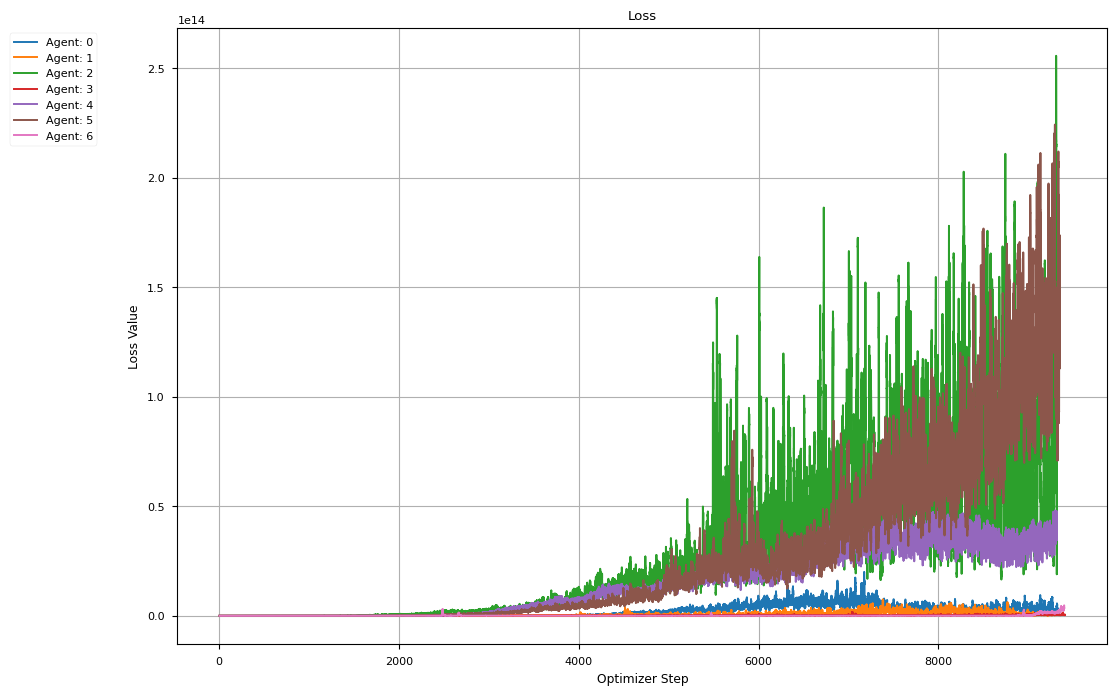

In [43]:
def smooth(x):
    return x.rolling(window=100).mean()

fig = plot_value(
    { key: os.path.join(value, 'agent', 'machine_loss.csv') for key, value in candidates.items() },
    info=dict(
        column='value',
        title='Loss',
        xlabel='Optimizer Step',
        ylabel='Loss Value',
        index='optimizer_step',
        ncols=1
    ),
    figsize=(12, 8),
    post_process_fn=smooth)

#### Reward

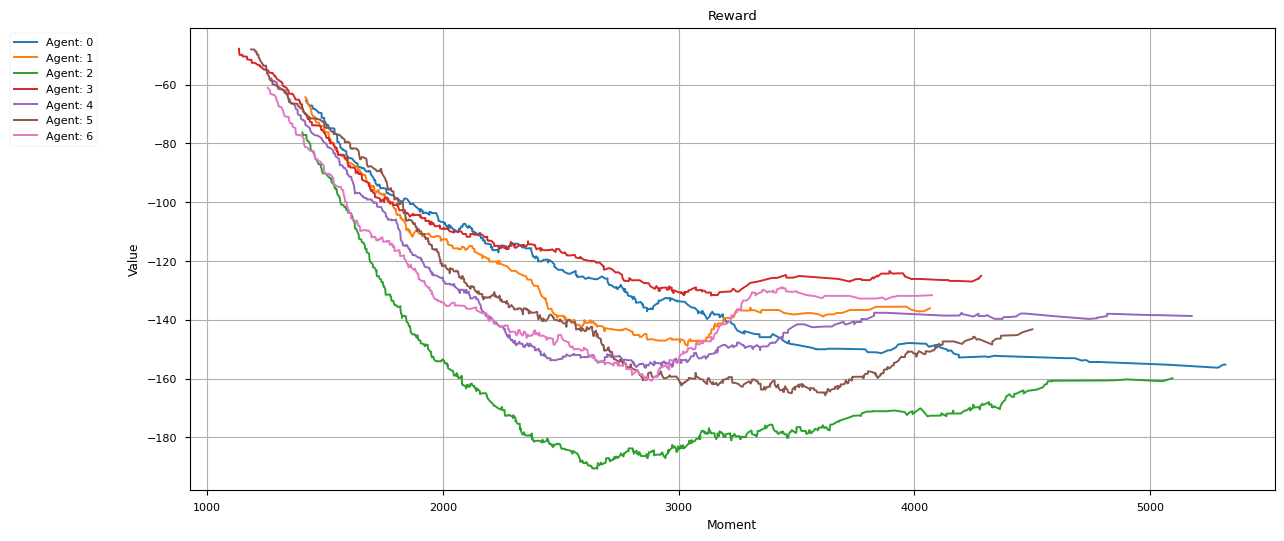

In [44]:
def sum(x):
    return x.rolling(window=400).sum()

run = '_1_40'
reward_files = { key: os.path.join(value, 'run', run, 'machine_reward.csv') for key, value in candidates.items() }

fig = plot_value(
    reward_files,
    info=dict(
        column='reward',
        title='Reward',
        xlabel='Moment',
        ylabel='Value',
        index='moment',
        is_reward_per_unit_visible=False,
        ncols=1,
        norm_index=True
    ),
    figsize=(14, 6),
    post_process_fn=sum
)


#### Cumulative Reward per Run

#### Reward per decision

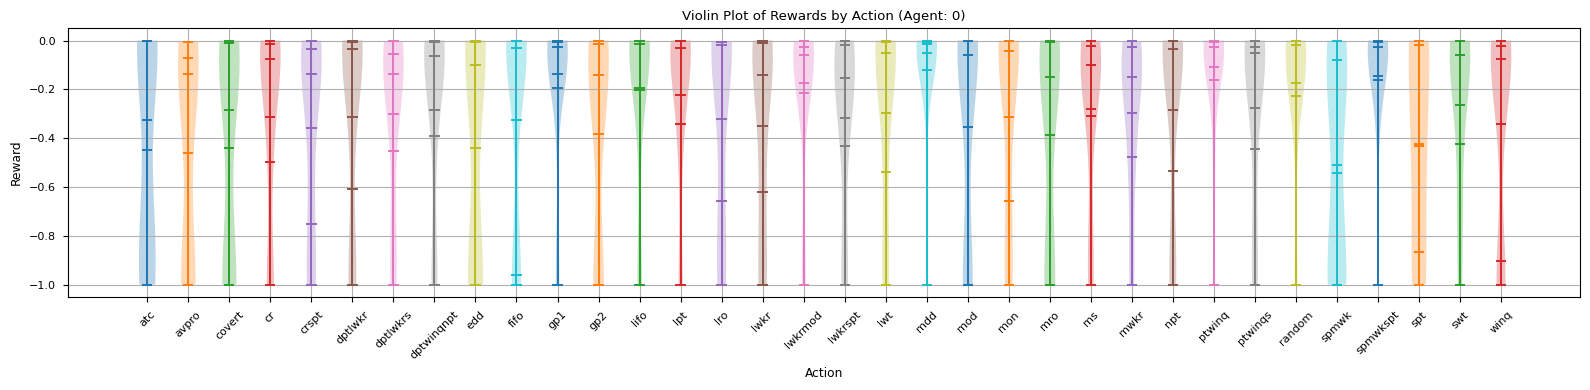

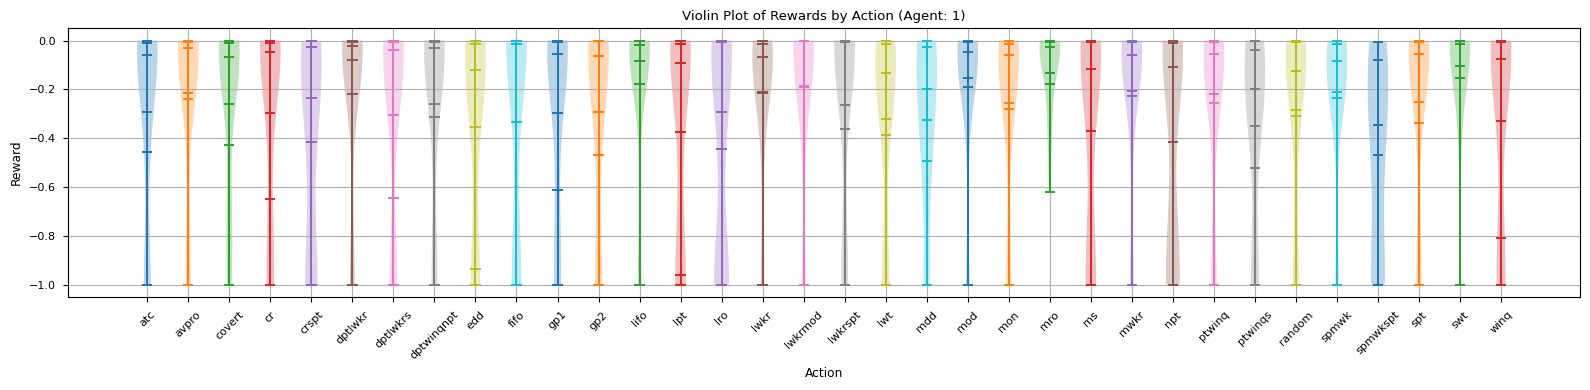

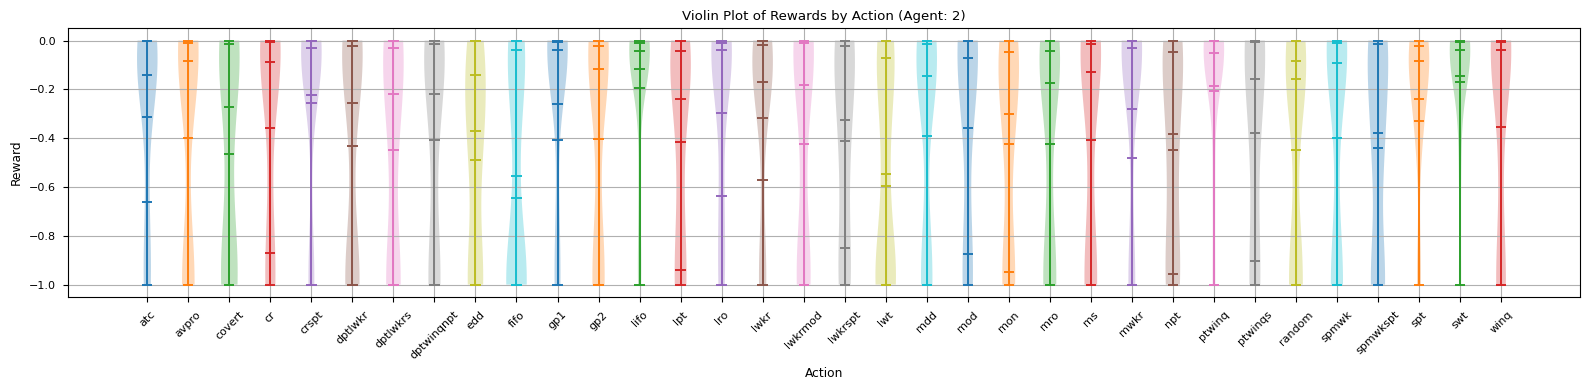

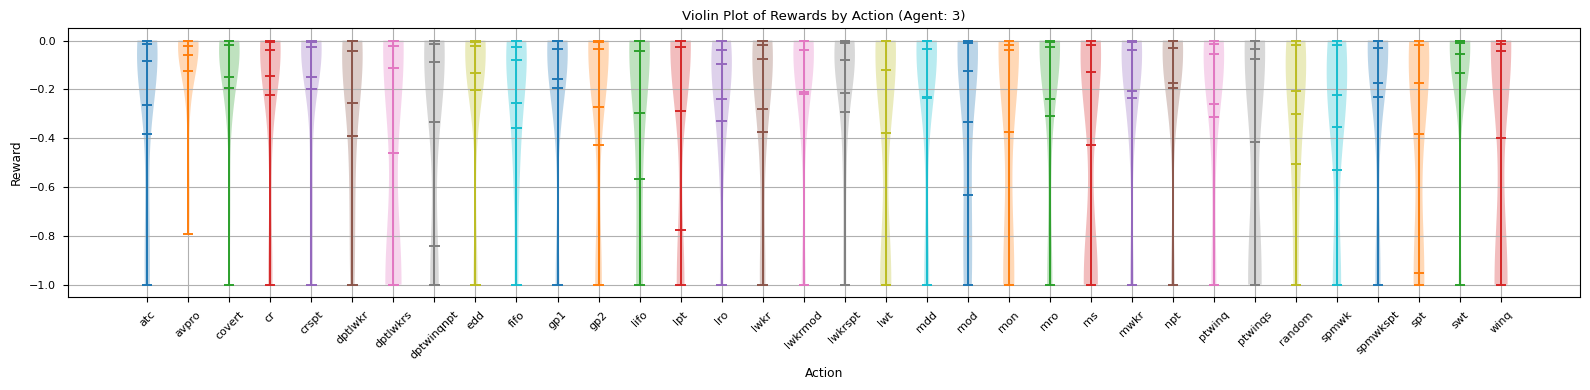

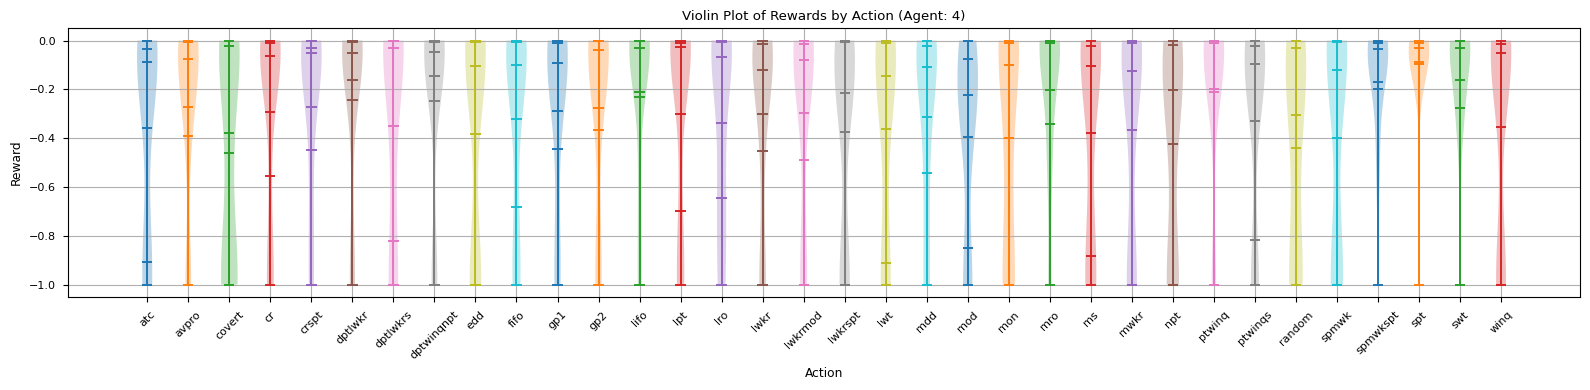

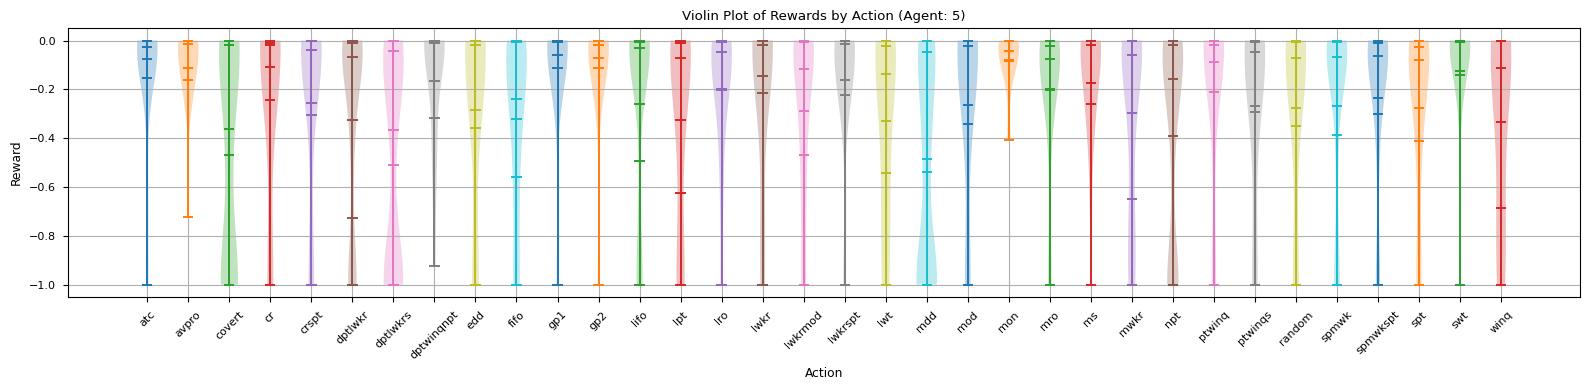

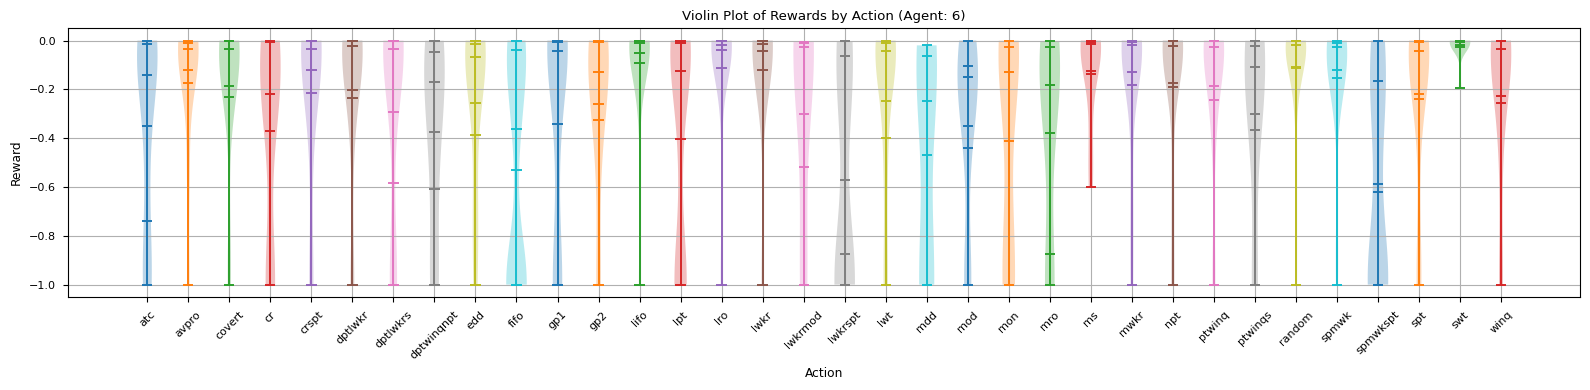

In [45]:
for name, path in reward_files.items():
    reward = pd.read_csv(path)

    reward['action'] = reward['action'].apply(lambda action: scheduling_action_map[action])

    plot_reward_distribution_per_action(reward, name, figsize=(16, 4))

#### Decisions

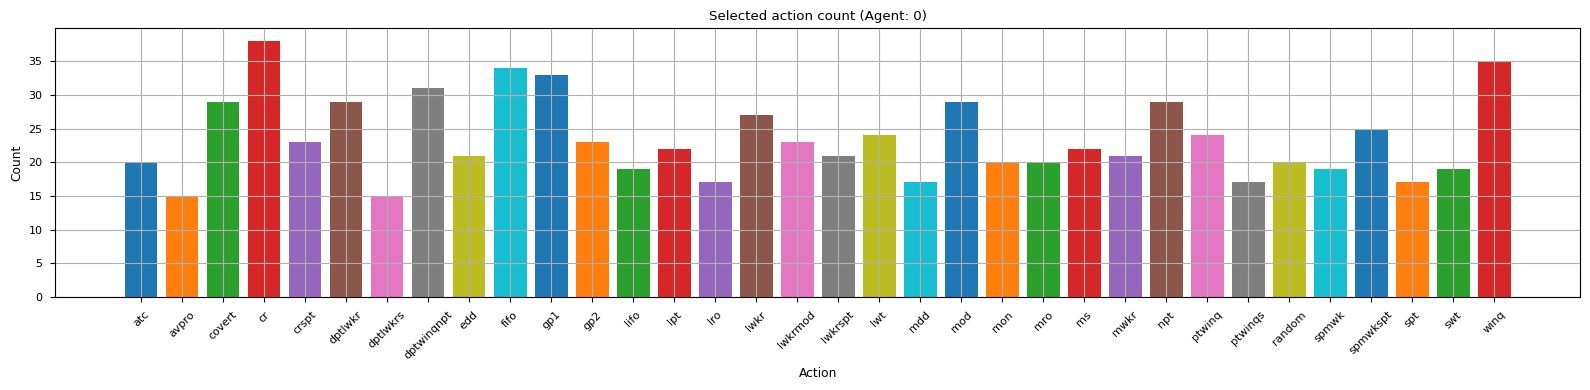

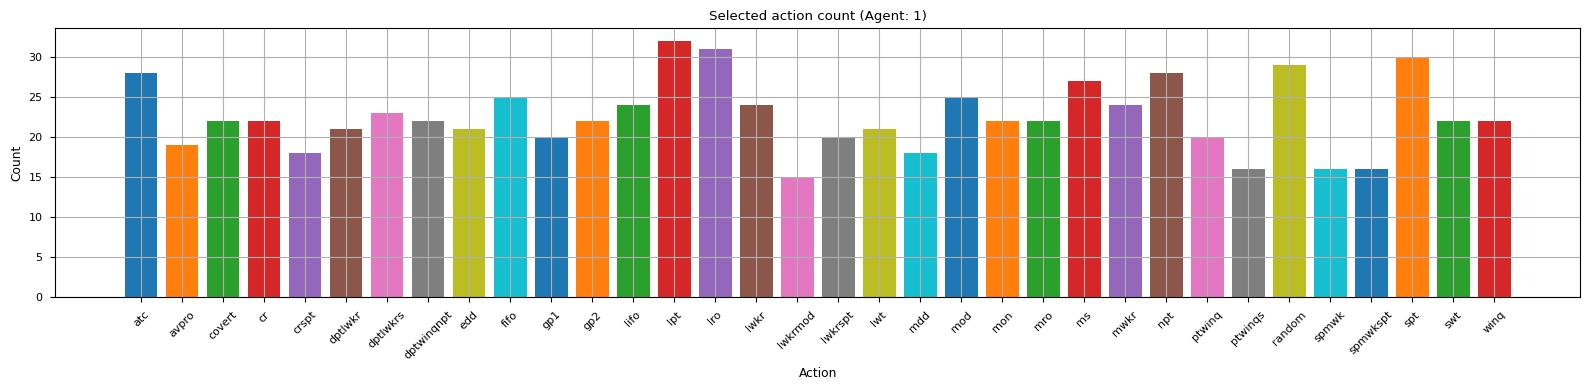

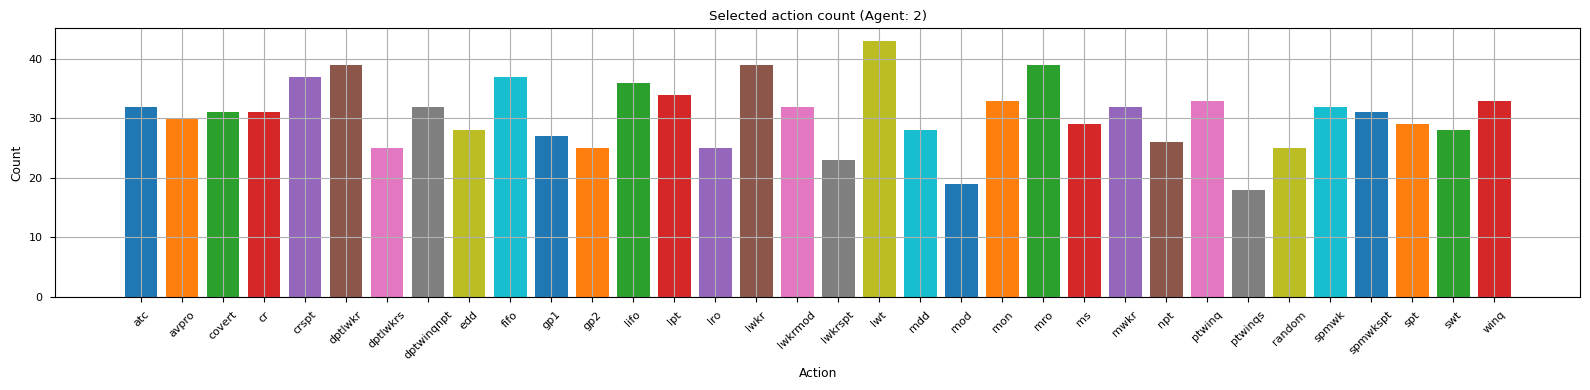

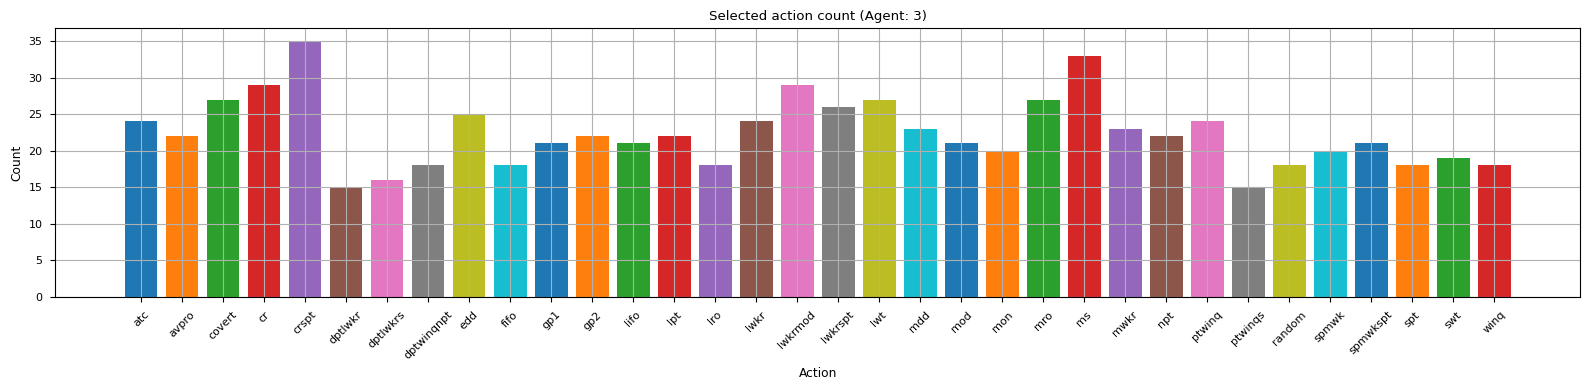

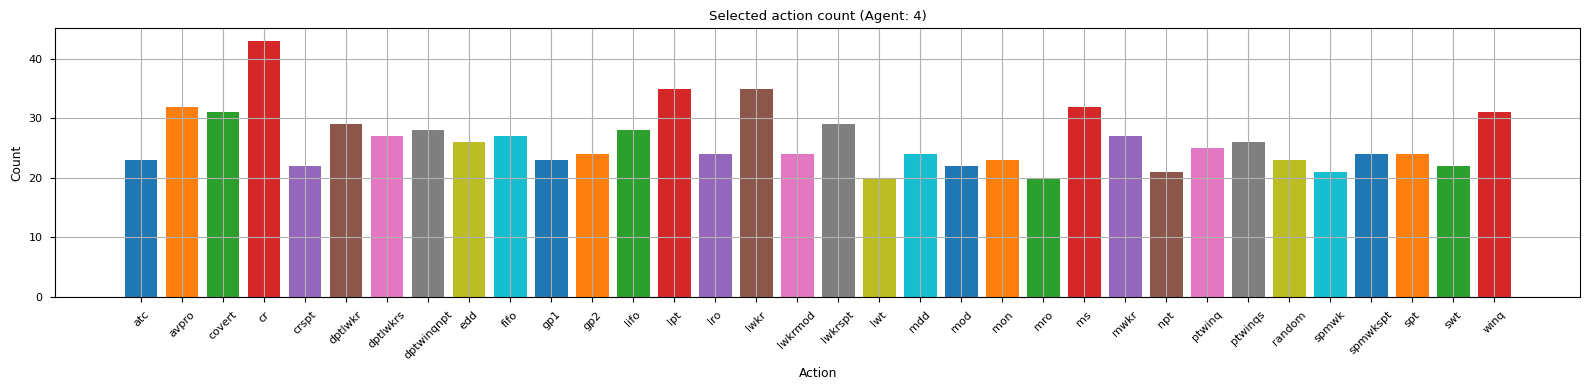

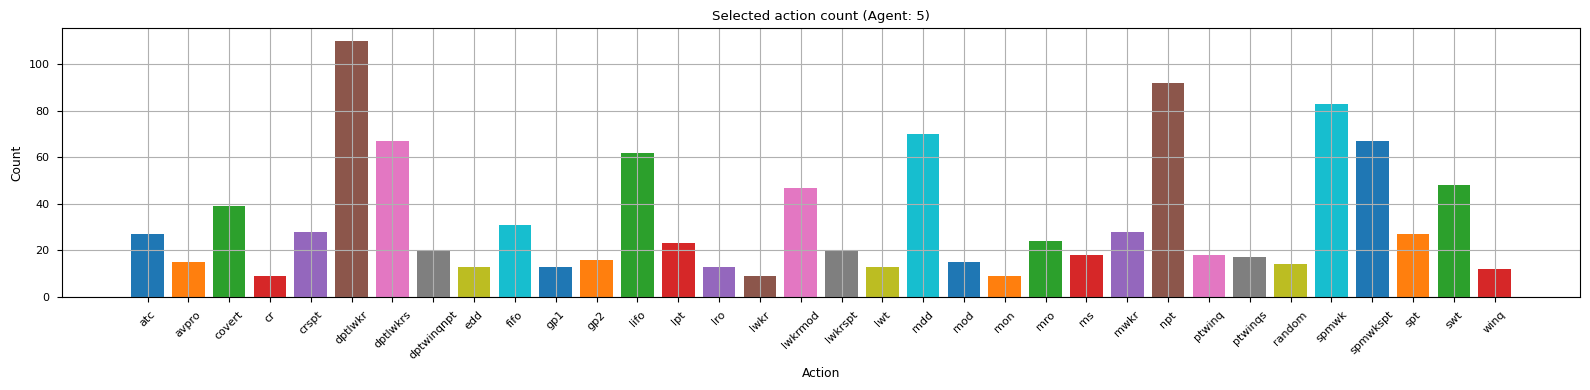

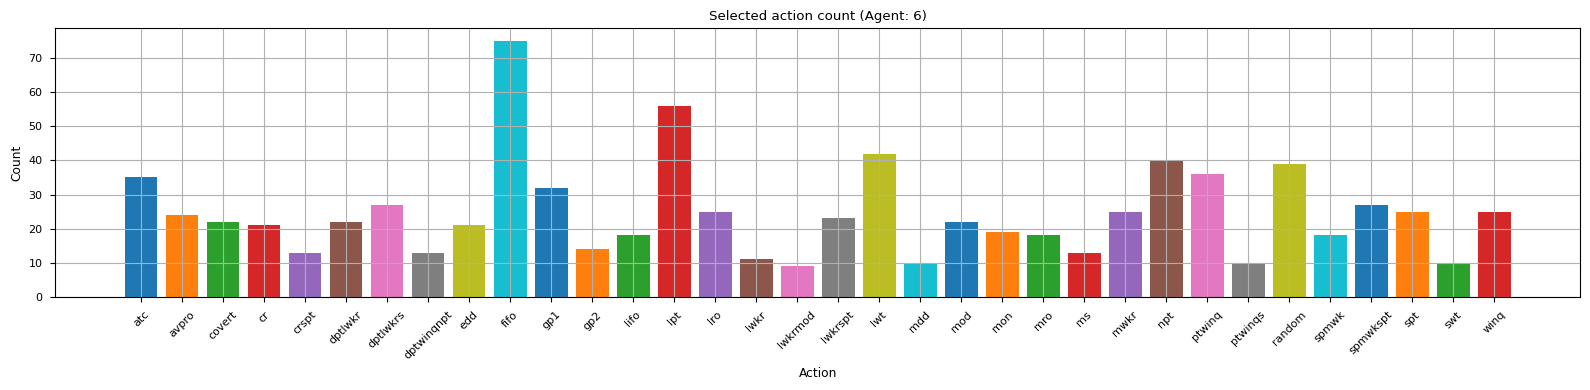

In [46]:
for name, path in reward_files.items():
    reward = pd.read_csv(path)

    reward['action'] = reward['action'].apply(lambda action: scheduling_action_map[action])

    plot_decisions_per_action(reward, name, figsize=(16, 4))

## Tournament

In [317]:
tournament_path = '../diploma_thesis/results/tournaments/deep_marl_direct'

In [318]:
report_path = os.path.join(tournament_path, 'report.txt')

with open(report_path) as f:
    result = f.readlines()

print(''.join(result))

+----------------------------------------+---------------------+---------------------+---------------------+
|               candidate                |   makespan_reward   |  tardiness_reward   |      total_sum      |
+----------------------------------------+---------------------+---------------------+---------------------+
|  PTWINQSSchedulingRule_CTRoutingRule   | 0.6457107636379078  |  0.766756892788986  | 1.4124676564268936  |
|    MWRKSchedulingRule_CTRoutingRule    |  0.691835627600085  | 0.7154079237149851  |  1.40724355131507   |
|    MONSchedulingRule_CTRoutingRule     | 0.6637290626531467  | 0.7267385634478961  | 1.3904676261010427  |
|               _model_321               | 0.6345551194972359  | 0.7095031213391155  | 1.3440582408363513  |
|               _model_49                | 0.6172822933876887  | 0.7003718800205528  | 1.3176541734082416  |
|               _model_278               | 0.6152941664331593  | 0.6975938088764533  | 1.3128879753096125  |
|               _mo

In [319]:
result_path = os.path.join(tournament_path, 'result.csv')
results = pd.read_csv(result_path)
results['candidate'] = results['candidate'].str.lstrip('_')

In [320]:
k = 10

top_k = results.groupby(['candidate']).sum().sort_values(by=['makespan_reward'], ascending=False).head(k).reset_index()['candidate']

top_k = set(top_k)

## Reward Distribution

In [321]:
df = results[results['run'].str.contains('tailard')].copy()
df = df[df['run'].str.contains('71|72|73|74|75|76|77|78|79|80')]

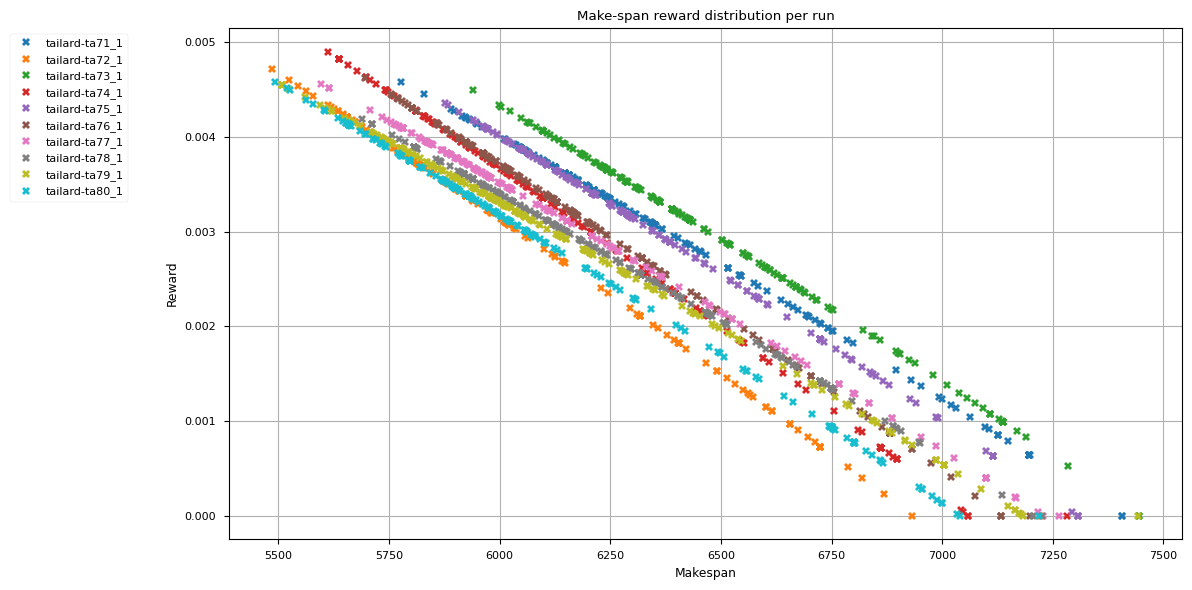

In [322]:
plot_reward_per_run(
    df,
    info=dict(
        title='Make-span reward distribution per run',
        xlabel='Makespan',
        ylabel='Reward',
        marker='X',
        metric='makespan',
        reward='makespan_reward',
        group='run',
        ncols=1,
        bbox_to_anchor=(-0.1, 1),
        figsize=(12, 6)
    ),
    format_group=lambda x: x.strip('_')
);

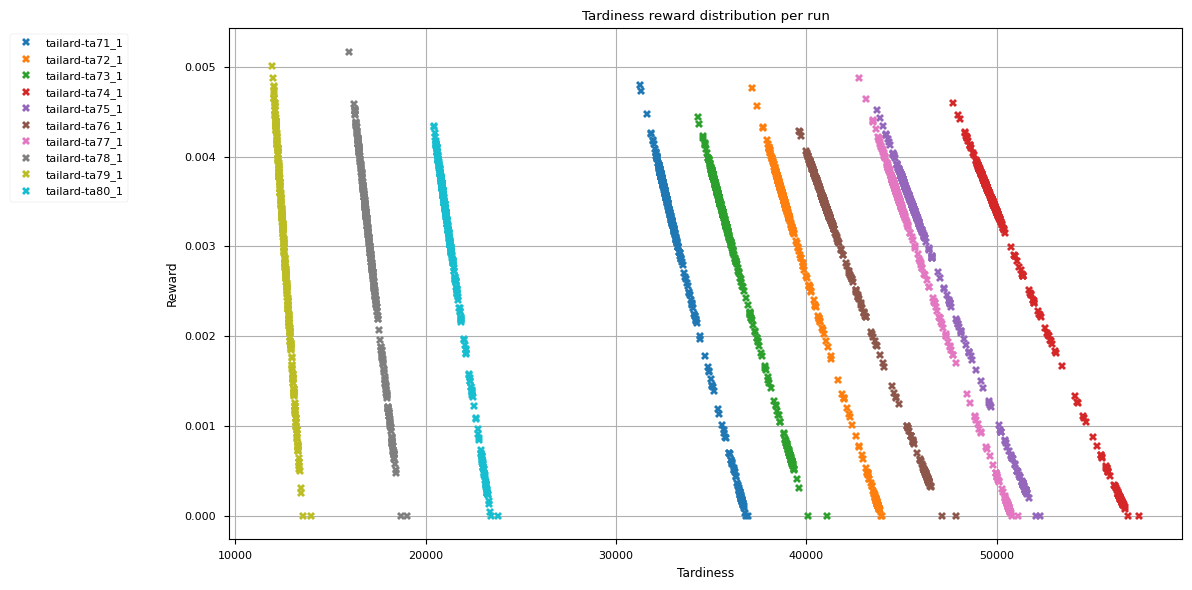

In [323]:
plot_reward_per_run(
    df,
    info=dict(
        title='Tardiness reward distribution per run',
        xlabel='Tardiness',
        ylabel='Reward',
        marker='X',
        metric='tardiness',
        reward='tardiness_reward',
        group='run',
        ncols=1,
        bbox_to_anchor=(-0.1, 1),
        figsize=(12, 6)
    ),
    format_group=lambda x: x.strip('_')
);

### Reward Distribution per model

In [324]:
df['candidate'] = df['candidate'].str.lstrip('_')

In [325]:
static_rules = list(df[~df['candidate'].str.contains('model')]['candidate'].unique())

run_filter = lambda p: True
run_filter = lambda p: p['simulator']['kind'] == 'episodic'

reward_filter = lambda p: True
reward_filter = lambda p: p['tape']['machine_reward']['kind'] == 'global_mdpi'

filter_models_ = lambda d, fn: filter_models(d, lambda p: run_filter(p) and reward_filter(p) and fn(p))

plain_dqn = filter_models_(datasets, lambda p:  len(p['machine_agent']['parameters']['mods']) == 0)

dueling_ddqn = filter_models_(
    datasets,
    lambda p: filter_by_mod(p, lambda mod: 'dueling' in mod) and
              filter_by_mod(p, lambda mod: 'ddqn' in mod) and
              not filter_by_mod(p, lambda mod: 'priori' in mod) and
              not filter_by_mod(p, lambda mod: '3_step' in mod))

dueling_ddqn_pr = filter_models_(
    datasets,
    lambda p: filter_by_mod(p, lambda mod: 'dueling' in mod) and
              filter_by_mod(p, lambda mod: 'ddqn' in mod) and
              filter_by_mod(p, lambda mod: 'priori' in mod) and
              not filter_by_mod(p, lambda mod: '3_step' in mod))

dueling_ddqn_pr_3_step = filter_models_(datasets,
                                        lambda p: filter_by_mod(p, lambda mod: 'dueling' in mod) and
                                                  filter_by_mod(p, lambda mod: 'ddqn' in mod) and
                                                  filter_by_mod(p, lambda mod: 'priori' in mod) and
                                                  filter_by_mod(p, lambda mod: '3_step' in mod))

reinforce = filter_models_(datasets, lambda p: 'reinforce' in p['machine_agent']['parameters']['base_path'])

ppo = filter_models_(datasets, lambda p: 'ppo' in p['machine_agent']['parameters']['base_path'])

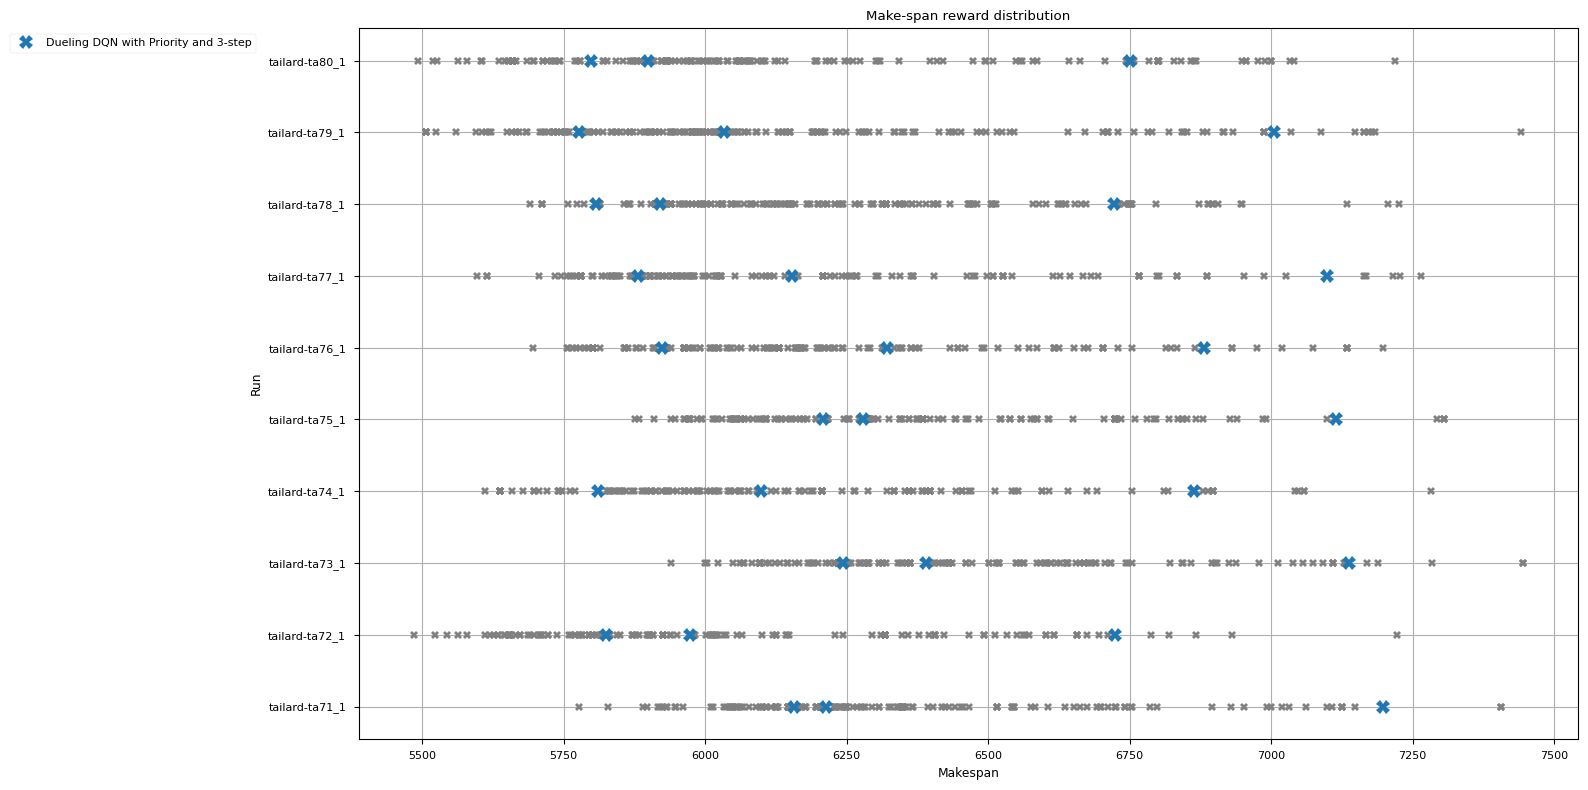

In [328]:
plot_performance_across_runs(
    df,
    info=dict(
        title='Make-span reward distribution',
        xlabel='Makespan',
        ylabel='Run',
        marker='X',
        metric='makespan',
        reward='makespan_reward',
        candidate_column='candidate',
        candidates=
        {
            # 'Static Rules': static_rules,
            # 'Plain DQN': plain_dqn,
            # 'Dueling DQN': dueling_ddqn,
            # 'Dueling DQN with Priority': dueling_ddqn_pr,
            'Dueling DQN with Priority and 3-step': dueling_ddqn_pr_3_step,
            # 'REINFORCE': reinforce,
            # 'PPO': ppo
        },
        group='run',
        ncols=1,
        figsize=(16, 8)
    )
);

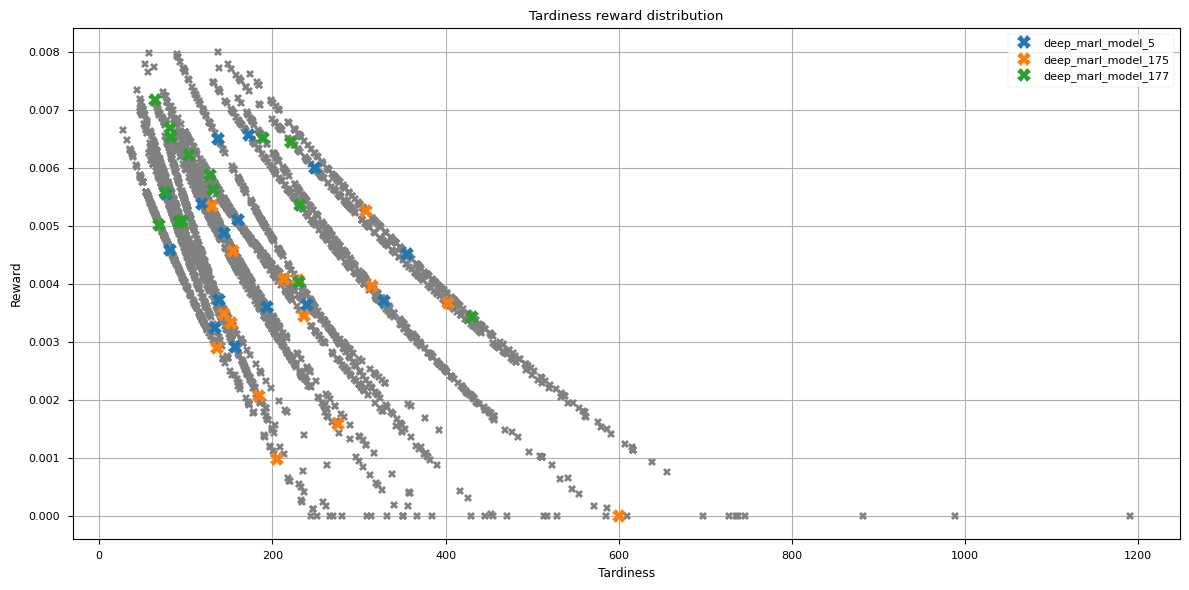

In [318]:
plot_reward_per_model_across_runs(
    results,
    info=dict(
        title='Tardiness reward distribution',
        xlabel='Tardiness',
        ylabel='Reward',
        marker='X',
        metric='tardiness',
        reward='tardiness_reward',
        candidate_column='candidate',
        candidates=models,
        group='run'
    )
);

#### Analyze results

In [23]:
reward_columns = [column for column in results.columns if 'reward' in column ]

results_per_candidate = results.copy()

results_per_candidate = results_per_candidate[['candidate', *reward_columns]].groupby(['candidate']).sum()
results_per_candidate['reward'] = 0

for column in reward_columns:
    results_per_candidate['reward'] += results_per_candidate[column]

results_per_candidate = results_per_candidate.sort_values(by=['reward'], ascending=False).reset_index()

results_per_candidate

,candidate,makespan_reward,tardiness_reward,reward
0,deep_marl_model_123,0.083460,0.079801,0.163262
1,deep_marl_model_78,0.075077,0.082871,0.157949
2,deep_marl_model_137,0.084218,0.073722,0.157940
3,deep_marl_model_89,0.077012,0.079193,0.156206
4,DPTWINQNPTSchedulingRule_CTRoutingRule,0.078611,0.076391,0.155002
...,...,...,...,...
217,FIFOSchedulingRule_CTRoutingRule,0.068385,0.036169,0.104554
218,LIFOSchedulingRule_CTRoutingRule,0.057569,0.039906,0.097476
219,LROSchedulingRule_CTRoutingRule,0.047264,0.049595,0.096859
220,NPTSchedulingRule_CTRoutingRule,0.055071,0.036829,0.091900


In [24]:
models = filter_models(dataset, lambda parameters: filter_by_mod(parameters, lambda mod: 'priori' in mod))

In [25]:
len(models)

96

In [26]:
candidates = results_per_candidate[results_per_candidate['candidate'].isin(models)]

candidates

,candidate,makespan_reward,tardiness_reward,reward


## Simulation Analysis

#### Utils

#### Main

In [262]:
run_path = '../diploma_thesis/tmp/test/run/_1/'

In [263]:
statistics = Statistics.load(run_path)

In [264]:
statistics.shop_floor_history.jobs[1].history.started_at

tensor([  0, 126, 218, 264, 295, 330, 350, 451, 503])

In [265]:
print(statistics.report())

+----+------------------------+--------------+------------------+------------+-------------+-------------+--------------+-------------+
|    | weighted_by_priority   |   total_jobs |   completed_jobs |   makespan |   flow_time |   tardiness |   tardy_jobs |   earliness |
|----+------------------------+--------------+------------------+------------+-------------+-------------+--------------+-------------|
|  0 | True                   |          265 |              257 |    9986.24 |     505.756 |     81.9114 |     0.540856 |     68.8455 |
|  1 | False                  |          265 |              257 |    9986.24 |  129979     |  21051.2    |   139        |  17693.3    |
+----+------------------------+--------------+------------------+------------+-------------+-------------+--------------+-------------+
+--------------------------+-----------+--------------------+----------------------------------+
|                    index |   runtime |   utilization_rate |   number_of_processed_ope

In [266]:
production_logs = statistics.production_logs

production_logs['event'].unique()

['created', 'dispatched', 'arrived_at_work_center', 'arrived_at_machine', 'started_processing', ..., 'completed', 'machine_breakdown', 'machine_repair', 'machine_decision', 'work_center_decision']
Length: 11
Categories (11, object): ['created' < 'dispatched' < 'arrived_at_work_center' < 'arrived_at_machine' ... 'work_center_decision' < 'machine_breakdown' < 'machine_repair' < 'completed']

#### Gantt

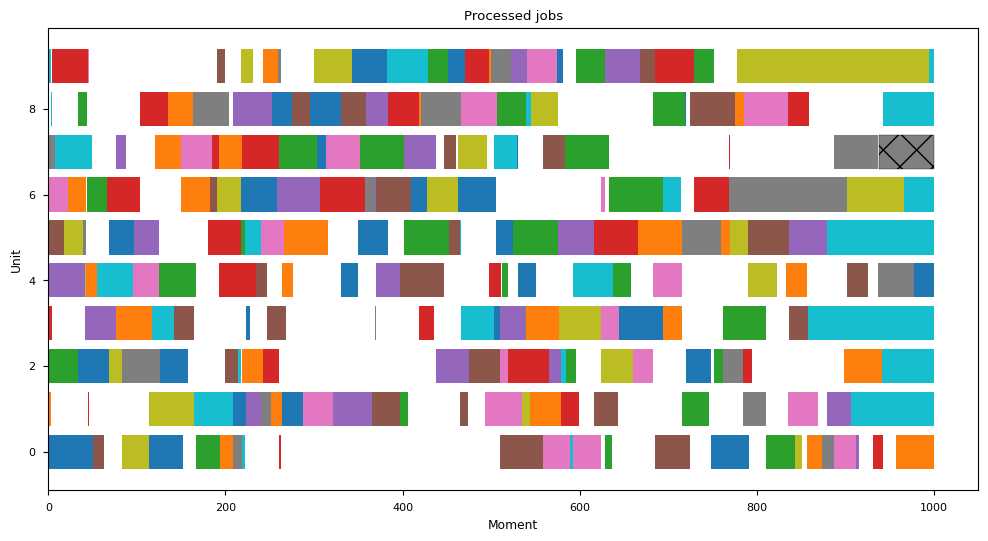

In [347]:
plot_gantt(
    production_logs,
    info=dict(
        window=[0, 1000],
        blocks=[
            dict(
                events=['started_processing', 'finished_processing'],
                style=dict()
            ),
            dict(
                events=['machine_breakdown', 'machine_repair'],
                style=dict(
                    color='gray',
                    edgecolor='black',
                    hatch='\\/'
                )
            )
        ],
        title='Processed jobs',
        xlabel='Moment',
        ylabel='Unit'
    )
);